In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pckgs.headline_preprocess import HeadlinePreprocess
from pckgs.helper import timeseries_to_supervised2
from pckgs.models import get_model_price, train_model, get_model_both_sent, get_model_both_emb
from pckgs.price_preprocess import PricePreprocess
from sklearn.model_selection import train_test_split
from pckgs.evaluator import Evaluator
import numpy as np
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_seq_items = 400

In [3]:
coins = {}
coin_names = ['BTC_USD', 'ETH_USD', 'XRP_USD', 'LTC_USD', 'BCH_USD', 'LINK_USD']
coin_dirs = []
for i in range(len(coin_names)): coin_dirs.append('./datasets/coinbase_hour_candles/' + coin_names[i] + '.feather')
coins = {coin_names[i]:coin_dirs[i] for i in range(len(coin_names))}
coins


problem = 'p'
# problem = 'pp'
# problem = 'pe'

start_date = ''
end_date = ''

lag = 21
# threshold = 0.0025
threshold = 0.1
pp = PricePreprocess(lag, threshold)

{'BTC_USD': './datasets/coinbase_hour_candles/BTC_USD.feather',
 'ETH_USD': './datasets/coinbase_hour_candles/ETH_USD.feather',
 'XRP_USD': './datasets/coinbase_hour_candles/XRP_USD.feather',
 'LTC_USD': './datasets/coinbase_hour_candles/LTC_USD.feather',
 'BCH_USD': './datasets/coinbase_hour_candles/BCH_USD.feather',
 'LINK_USD': './datasets/coinbase_hour_candles/LINK_USD.feather'}

In [11]:
##one coin
# candle = pd.read_feather(coins['ETH_USD'])
# candle.set_index('time', inplace=True)
# candle.index = candle.index.tz_localize(None)



#many coins (can specify which...)
candle = pd.DataFrame()
for coin in coins:
    candle = pd.read_feather(coins[coin])
    candle.set_index('time', inplace=True)
    candle.index = candle.index.tz_localize(None)
    # candle = pd.concat([candle, candle_temp])
    # sb.lineplot(data=candle, x=candle.index, y='close', label=coin)
candle

,open,high,low,close,volume
time,,,,,
2014-12-01 07:00:00,370.0,370.0,370.0,370.0,0.036556
2014-12-01 08:00:00,370.0,370.0,370.0,370.0,0.000000
2014-12-01 09:00:00,370.0,370.0,370.0,370.0,0.000000
2014-12-01 10:00:00,370.0,370.0,370.0,370.0,0.000000
2014-12-01 11:00:00,370.0,370.0,370.0,370.0,0.000000
...,...,...,...,...,...
2020-06-25 19:00:00,4.0,4.0,4.0,4.0,310124.721999
2020-06-25 20:00:00,4.0,4.0,4.0,4.0,167599.639030
2020-06-25 21:00:00,4.0,4.0,4.0,4.0,333894.597678


In [5]:
positions = pp.preprocess(candle)
# positions


 Value of observations: 

up      17298
down    16656
same     6506
Name: pChange, dtype: int64


,pChange_scaled_t-1,pChange_scaled_t-2,pChange_scaled_t-3,pChange_scaled_t-4,pChange_scaled_t-5,pChange_scaled_t-6,pChange_scaled_t-7,pChange_scaled_t-8,pChange_scaled_t-9,pChange_scaled_t-10,...,pChange_scaled_t-14,pChange_scaled_t-15,pChange_scaled_t-16,pChange_scaled_t-17,pChange_scaled_t-18,pChange_scaled_t-19,pChange_scaled_t-20,down,same,up
time,,,,,,,,,,,,,,,,,,,,,
2016-05-18 22:00:00,0.050576,0.050576,0.016328,-0.097288,0.050576,0.050576,0.050576,0.050576,0.050576,0.050576,...,0.050576,0.050576,0.050576,0.050576,0.050576,0.013872,0.488483,1,0,0
2016-05-18 23:00:00,-0.094990,0.050576,0.050576,0.016328,-0.097288,0.050576,0.050576,0.050576,0.050576,0.050576,...,0.050576,0.050576,0.050576,0.050576,0.050576,0.050576,0.013872,0,1,0
2016-05-19 00:00:00,0.050576,-0.094990,0.050576,0.050576,0.016328,-0.097288,0.050576,0.050576,0.050576,0.050576,...,0.050576,0.050576,0.050576,0.050576,0.050576,0.050576,0.050576,0,0,1
2016-05-19 01:00:00,0.070284,0.050576,-0.094990,0.050576,0.050576,0.016328,-0.097288,0.050576,0.050576,0.050576,...,0.050576,0.050576,0.050576,0.050576,0.050576,0.050576,0.050576,0,1,0
2016-05-19 02:00:00,0.050576,0.070284,0.050576,-0.094990,0.050576,0.050576,0.016328,-0.097288,0.050576,0.050576,...,0.050576,0.050576,0.050576,0.050576,0.050576,0.050576,0.050576,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-29 13:00:00,0.056396,0.104218,0.115271,0.078756,0.057155,0.065457,0.064985,0.087819,-0.100584,0.070201,...,0.047371,0.004135,-0.020289,0.100193,0.037397,0.057315,0.112660,1,0,0
2020-12-29 14:00:00,0.041076,0.056396,0.104218,0.115271,0.078756,0.057155,0.065457,0.064985,0.087819,-0.100584,...,0.075304,0.047371,0.004135,-0.020289,0.100193,0.037397,0.057315,0,1,0
2020-12-29 15:00:00,0.054838,0.041076,0.056396,0.104218,0.115271,0.078756,0.057155,0.065457,0.064985,0.087819,...,-0.027936,0.075304,0.047371,0.004135,-0.020289,0.100193,0.037397,1,0,0


In [6]:
y = positions.loc[:, ['down', 'same', 'up']]
if problem == 'p':
    x = positions.drop(['down', 'same', 'up'], axis=1)
elif problem =='pp':
    x = positions.drop(['down', 'same', 'up'], axis=1)
    sentiment = pd.read_csv('../Text/datasets/headline_sentiment_mean.csv', index_col='date', parse_dates=['date'])
    sentiment_score = timeseries_to_supervised2(sentiment, lag=21)
    sentiment_score.dropna(inplace=True)
    sentiment_score.drop('sentiment_score_t', axis=1, inplace=True)
    x2 = sentiment_score
    x = x2.merge(x, left_index=True, right_on=pd.to_datetime(x.index.strftime('%Y-%m-%d')), how='right').dropna()
    x.drop(columns='key_0', inplace=True)
    x = x.values.reshape((len(x), int(len(x.columns) / 2), 2), order='F')
elif problem =='pe':
    x = positions.drop(['down', 'same', 'up'], axis=1)
    headline = pd.read_csv('../Text/datasets/headline_embeddings_mean.csv', index_col='date', parse_dates=['date'])
    x2 = HeadlinePreprocess.shape_vectors(headline, lag, y.index)

                        0_t-1     1_t-1     2_t-1     3_t-1     4_t-1  \
time                                                                    
2016-05-18 22:00:00  0.059251 -0.060528  0.221884  0.214606  0.119504   
2016-05-18 23:00:00  0.059251 -0.060528  0.221884  0.214606  0.119504   
2016-05-19 00:00:00 -0.059913 -0.012410  0.014516 -0.329916 -0.156510   
2016-05-19 01:00:00 -0.059913 -0.012410  0.014516 -0.329916 -0.156510   
2016-05-19 02:00:00 -0.059913 -0.012410  0.014516 -0.329916 -0.156510   

                        5_t-1     6_t-1     7_t-1     8_t-1     9_t-1  ...  \
time                                                                   ...   
2016-05-18 22:00:00 -0.012858  0.205291  0.110251  0.574956  0.081143  ...   
2016-05-18 23:00:00 -0.012858  0.205291  0.110251  0.574956  0.081143  ...   
2016-05-19 00:00:00  0.112402 -0.021958 -0.212159  0.160066  0.158078  ...   
2016-05-19 01:00:00  0.112402 -0.021958 -0.212159  0.160066  0.158078  ...   
2016-05-19 02:00:00 

In [ ]:
#case of one coin
if problem == 'p' or problem =='pp':
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
elif problem == 'pe':
    x1_train, x1_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
    x2_train, x2_test, _, _ = train_test_split(x2, y, test_size=0.2, shuffle=False)
    del _
    x_train = [x1_train, x2_train]
    x_test = [x1_test, x2_test]

#case of many coins


test_index = y_test.index
train_index = y_train.index

In [10]:
#create labeled y_test to measure pnl, confusion matrix
y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_test_labeled = y_test_labeled.idxmax(axis=1)

y_train_labeled = y_train.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_train_labeled = y_train_labeled.idxmax(axis=1)

In [11]:
test_candle = candle.reindex(test_index)
train_candle = candle.reindex(train_index)

In [42]:
if problem == 'p':
    model = get_model_price()
    model, history = train_model(model, (x_train, x_test, y_train, y_test), '../models/model_price.h5', epochs=2)
elif problem =='pp':
    model = get_model_both_sent()
    model, history = train_model(model, (x_train, x_test, y_train, y_test), '../models/model_both_sent.h5', epochs=2)
elif problem =='pe':
    model = get_model_both_emb()
    model, history = train_model(model, (x_train, x_test, y_train, y_test), '../models/model_both_sent.h5', epochs=2)

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

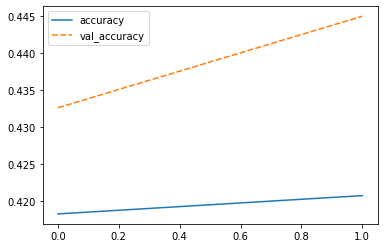

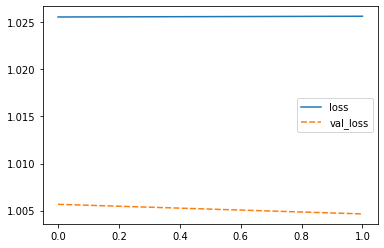

In [44]:
ac = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
plt.figure()
sb.lineplot(data=ac)

loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
plt.figure()
sb.lineplot(data=loss)

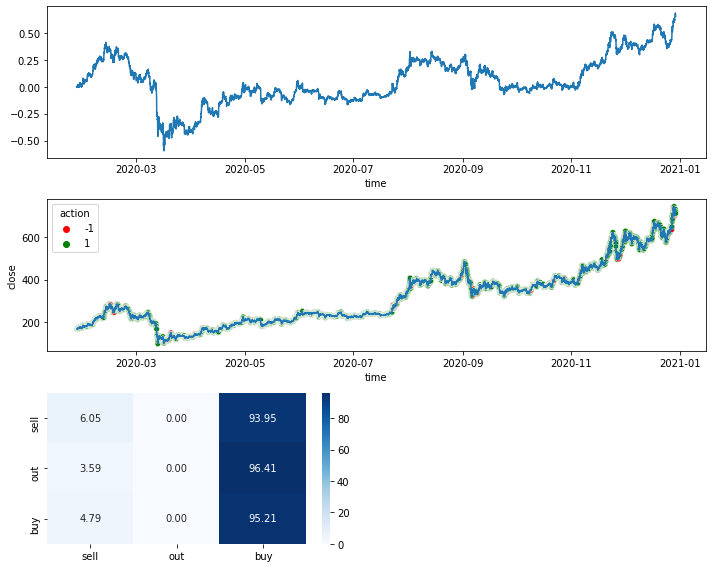

              precision    recall  f1-score   support

          -1       0.48      0.06      0.11      3324
           0       0.00      0.00      0.00      1197
           1       0.44      0.95      0.60      3571

    accuracy                           0.45      8092
   macro avg       0.31      0.34      0.24      8092
weighted avg       0.39      0.45      0.31      8092



/home/solon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
#create labeled y_pred for pnl, confusion matrix
y_pred = model.predict(x_test)
y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=test_index)
y_pred_labeled = y_pred_labeled.idxmax(axis=1)

Evaluator.evaluate(y_pred_labeled, y_test_labeled, test_candle)
print(classification_report(y_test_labeled, y_pred_labeled))

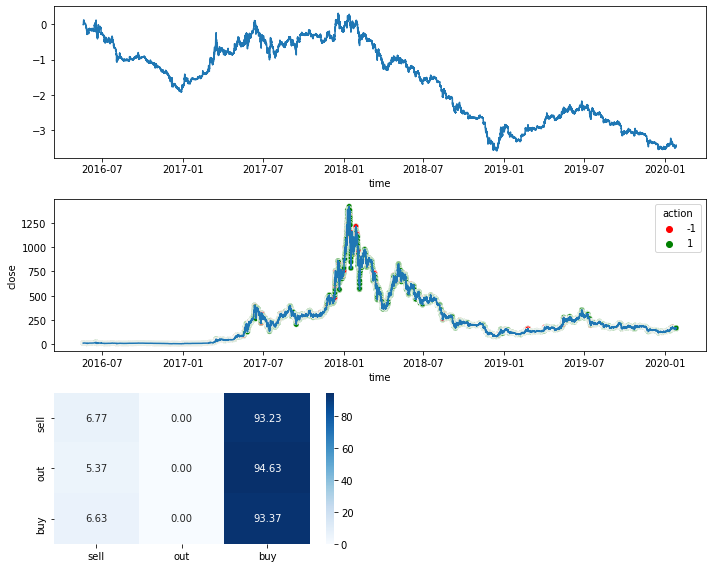

              precision    recall  f1-score   support

          -1       0.43      0.07      0.12     13332
           0       0.00      0.00      0.00      5309
           1       0.42      0.93      0.58     13727

    accuracy                           0.42     32368
   macro avg       0.28      0.33      0.23     32368
weighted avg       0.36      0.42      0.30     32368



/home/solon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
y_predt = model.predict(x_train)
y_predt_labeled = pd.DataFrame(y_predt, columns=[-1, 0, 1], index=train_index)
y_predt_labeled = y_predt_labeled.idxmax(axis=1)

Evaluator.evaluate(y_predt_labeled, y_train_labeled, train_candle)
print(classification_report(y_train_labeled, y_predt_labeled))